# Blending
# Introduction
Blending是基于Stacking的集成学习。 在Stacking集成学习的方法里面， 它分为两层，第一层里面多个模型(可以相同架构也可以不一样架构)直接从原来的训练集进行学习并预测输出。之后把第一层多个模型的输出作为第二层模型的输入对第二层模型进行训练。

Stacking的思路就好比上课时我上课迟到，我需要从其他同学的笔记里面进行学习归纳。这样子其他同学就相当于第一层的模型，直接从老师(数据)学习。而我就相当于第二层模型，从第一层模型的输出进行学习。

而在Stacking里面， 在第一层的模型是通过K-fold Cross validation 形式进行训练和预测。 而Blending的思路相对于把K-fold Cross validation换成Hold-Out。
以下是Stacking 步骤:

<img src=https://pic1.zhimg.com/80/v2-490b92e364070e07a4bd39d514000748_720w.jpg>
(图片来源: https://zhuanlan.zhihu.com/p/91659366)

# Blending
1. 将数据划分为训练集和测试集(test_set)，其中训练集需要再次划分为训练集(train_set)和验证集
(val_set)；
2. 创建第一层的多个模型，这些模型可以使同质的也可以是异质的；
3. 使用train_set训练步骤2中的多个模型，然后用训练好的模型预测val_set和test_set得到val_predict,
test_predict1；
4. 创建第二层的模型,使用val_predict作为训练集训练第二层的模型；
5. 使用第二层训练好的模型对第二层测试集test_predict1进行预测，该结果为整个测试集的结果。
6. Blending图解
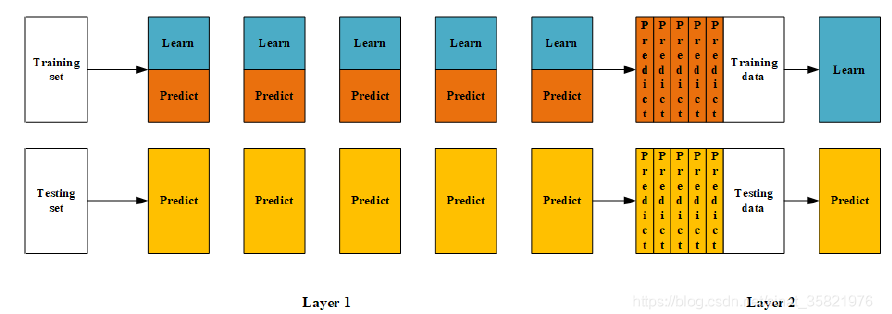

# Properties
### 优点
+ 相对于Stacking, blending 用holdout更加简单
+ 不需要太多理论分析
### 缺点
+ 只用了holdout的数据集预测作为第二层的训练集，浪费数据
+ 因为holdout数据用的少，输入第二层的数据很有可能导致模型overfitting
+ 相对于Stacking, 因为用了Holdout而不是K-fold CV,不够robust

# Reference
[1] https://zhuanlan.zhihu.com/p/91659366

# Source Code for blending

# 1. Using artificial dataset 

In [49]:
# 加载相关工具包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

In [50]:

from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# load dataset
data, target = make_blobs(n_samples=10000, centers=2, random_state=1, cluster_std=1.0 )
#split training set and testing set
X_train1,X_test,y_train1,y_test = train_test_split(data, target, test_size=0.2,
random_state=1)
X_train,X_val,y_train,y_val = train_test_split(X_train1, y_train1, test_size=0.3,
random_state=1)
print("The shape of training X:",X_train.shape)
print("The shape of training y:",y_train.shape)
print("The shape of test X:",X_test.shape)
print("The shape of test y:",y_test.shape)
print("The shape of validation X:",X_val.shape)
print("The shape of validation y:",y_val.shape)

The shape of training X: (5600, 2)
The shape of training y: (5600,)
The shape of test X: (2000, 2)
The shape of test y: (2000,)
The shape of validation X: (2400, 2)
The shape of validation y: (2400,)


In [51]:
y_test

array([1, 1, 1, ..., 0, 1, 1])

In [57]:
# 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# First stage models
clfs = [SVC(probability = True),RandomForestClassifier(n_estimators=5, n_jobs=-1,criterion='gini'),KNeighborsClassifier()]

# second stage models
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [58]:
val_features = np.zeros((X_val.shape[0],len(clfs))) # 初始化验证集结果
test_features = np.zeros((X_test.shape[0],len(clfs))) # 初始化测试集结果
for i,clf in enumerate(clfs):
  clf.fit(X_train,y_train)
  val_fea = clf.predict_proba(X_val)[:, 1]
  test_fea = clf.predict_proba(X_test)[:,1]
  val_features[:,i] = val_fea
  test_features[:,i] = test_fea


In [59]:
lr.fit(val_features,y_val)
# 输出预测的结果
from sklearn.model_selection import cross_val_score
cross_val_score(lr,test_features,y_test,cv=5)

array([1., 1., 1., 1., 1.])

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


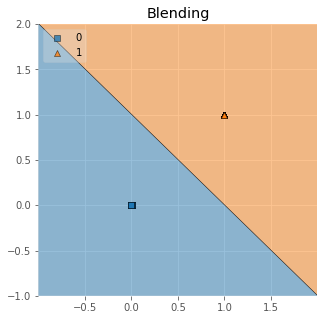

In [61]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
# Visualize stage 2 model outputs from Blending and decision boundary using predictions from 2 models only
lr = LogisticRegression()
lr.fit(val_features[:,:2], y_val)

# plot decision boundary
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
fig = plot_decision_regions(X=test_features[:,:2], y=y_test, clf=lr,legend=2)
plt.title("Blending")
plt.show()

In [62]:
val_features[:,:2],

(array([[1.90396043e-04, 0.00000000e+00],
        [4.84535489e-04, 0.00000000e+00],
        [9.99999861e-01, 1.00000000e+00],
        ...,
        [9.99999902e-01, 1.00000000e+00],
        [9.99999460e-01, 1.00000000e+00],
        [9.99999878e-01, 1.00000000e+00]]),)

# 2. 作业 Iris dataset with blending

In [65]:
from sklearn.datasets import load_iris
data= load_iris()

In [66]:
iris_data, target = data['data'], data['target']
from sklearn.model_selection import train_test_split
X_train1,X_test,y_train1,y_test = train_test_split(iris_data, target, test_size=0.2,
random_state=2)
X_train,X_val,y_train,y_val = train_test_split(X_train1, y_train1, test_size=0.3,
random_state=2)


In [67]:
# stage 1 models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

iris_clfs = [SVC(probability = True),RandomForestClassifier(n_estimators=5, n_jobs=-1,criterion='gini'),KNeighborsClassifier()]
# stage 2 models
logit_clf = LogisticRegression()

In [68]:
# build features using first stage predictions
val_fea, test_fea = np.zeros([y_val.shape[0], len(iris_clfs)]), np.zeros([y_test.shape[0], len(iris_clfs)])
for i, clf in enumerate(iris_clfs):
  clf.fit(X_train, y_train)
  val_feature = clf.predict_proba(X_val)[:, 1]
  test_feature = clf.predict_proba(X_test)[:,1]
  val_fea[:,i] = val_feature
  test_fea[:,i] = test_feature
# val_fea.shape, test_fea.shape

In [69]:
# stage 2 model 
logit_clf.fit(val_fea, y_val)
from sklearn.model_selection import cross_val_score
cross_val_score(logit_clf,test_fea,y_test,cv=5)

array([0.66666667, 0.66666667, 0.83333333, 0.66666667, 0.66666667])

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


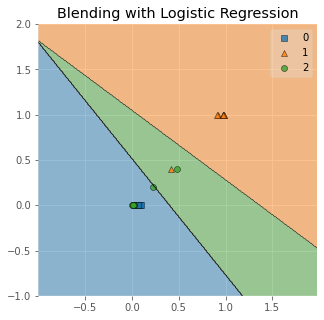

In [85]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
# Visualize stage 2 model outputs from Blending and decision boundary using predictions from 2 models only
logit_clf = LogisticRegression()
fea_idx = [0,2]
logit_clf.fit(val_fea[:,fea_idx], y_val)

# plot decision boundary
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
fig = plot_decision_regions(X=test_fea[:,fea_idx], y=y_test, clf=logit_clf)
plt.title("Blending with Logistic Regression")
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


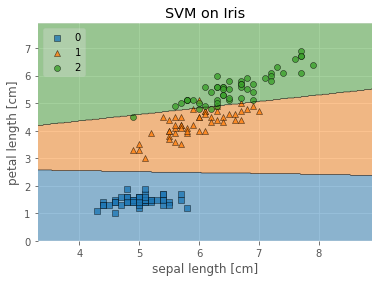

In [74]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]

y = iris.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)


# Plotting decision regions
plot_decision_regions(X, y, clf=svm, legend=2)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')
plt.show()

# 3. Visualize Decision Bounardy of different models

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(),

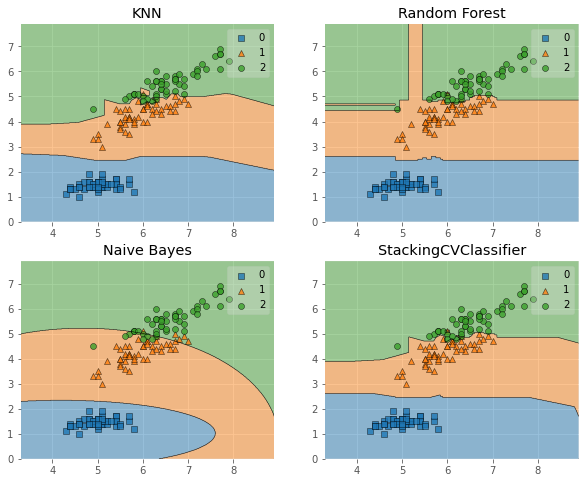

In [79]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingCVClassifier
RANDOM_SEED = 42
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()
# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
# classifiers: stage 1 models,  meta_classifier: stage 2 models
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)


gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
tuples = zip([clf1, clf2, clf3, sclf],['KNN','Random Forest','Naive Bayes','StackingCVClassifier'],itertools.product([0, 1], repeat=2))
for clf, lab, grd in tuples:
  clf.fit(X, y)
  ax = plt.subplot(gs[grd[0], grd[1]])
  fig = plot_decision_regions(X=X, y=y, clf=clf)
  plt.title(lab)
plt.show()